<table style="float:left; border:none">
   <tr style="border:none">
       <td style="border:none">  
           <img 
               src="../images/EmpleaFidelidad.png" 
               style="width:200px"
           >
           </a>    
       </td>
   </tr>
</table>
<div style="float:right;font-size: 20px;"><h2>IBM - 03 - Random Forest Classifier</h2></div>

<a id="top"></a> <br>
## Índice
1. [Carga de paquetes y datos](#1)<br>
    1.1. [Librerías y clases](#11)<br>
    1.2. [Lectura de datos](#12)<br>
    1.3. [Filtrado de variable target](#13)<br>
2. [Modelo](#2)<br>
    2.1. [Separación en train y test](#21)<br>
    2.2. [Target encoding](#22)<br>
    2.3. [Métrica para optimización de hiperparámetros](#23)<br>
    2.4. [Preprocesamiento](#24)<br>
    2.5. [Pipe modelo](#25)<br>
    2.6. [Optimización de hiperparámetros con Optuna](#26)<br>
    2.7. [Visualización de hiperparámetros](#27)<br>
    2.8. [Entrenamiento del modelo con mejores hiperparámetros](#28)<br>
3. [Evaluación del modelo](#3)<br>
    3.1. [Métricas principales](#31)<br>
    3.2. [Reporte de clasificación](#32)<br>
    3.3. [Matriz de confusión](#33)<br>
    3.4. [ROC curve](#34)<br>
    3.5. [Precission-Recall Curve](#35)<br>
    3.6. [Feature importance](#36)<br>
4. [Exportación con Shelve](#4)<br>
    4.1. [Exportación con Shelve](#41)<br>

***
<a id="1"></a> <br>
## 1. Carga de paquetes y datos

<a id="11"></a>
### 1.1. Librerías y clases

In [29]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib. pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import *
from sklearn import preprocessing
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler,  FunctionTransformer, LabelEncoder, binarize
from sklearn.pipeline import make_pipeline, make_union
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
from imblearn.pipeline import Pipeline 
from sklearn.inspection import permutation_importance
import shelve
import plotly.io as pio
pio.renderers.default = 'iframe'
import optuna

import warnings
warnings.filterwarnings("ignore")

In [3]:
# Esta clase permite dropear columnas de un DataFrame dentro de un pipeline

class ColumnDropper(BaseEstimator, TransformerMixin):
    def __init__(self,columns):
        self.columns=columns

    def transform(self,X,y=None):
        return X.drop(self.columns,axis=1)

    def fit(self, X, y=None):
        return self  

<a id="12"></a>
### 1.2. Lecura de datos

In [4]:
# Carga de dataset
key= "ibm.clean.Education.csv"
path="../Data/"
df = pd.read_csv(path + key)
df.sample(3)

,EmployeeID,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,...,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Employee Source,AgeStartedWorking
2429,1552,44,0,Travel_Rarely,Sales,28,Bachelor,Medical,4,Male,...,1,28,1,4,7,7,4,3,Recruit.net,16
1656,2920,57,0,Travel_Rarely,Sales,29,Bachelor,Marketing,3,Female,...,1,15,3,3,15,12,5,11,Indeed,42
1971,3528,49,0,Travel_Rarely,Sales,8,Master,Technical Degree,4,Male,...,1,22,3,3,9,8,2,3,Indeed,27


<a id="13"></a>
### 1.3. Filtrado de variable target

**Se eliminan todas las instancias con valor de Attrition igual a "Terminated" ya que el modelo estima la probabilidad de que un empleado renuncie a la compañia**

In [5]:
#Elimino las instancias con valor "Termination" de la columna "Attrition"
df = df[df["Attrition"] != "Termination"]

***
<a id="2"></a> <br>
## 2. Modelo

<a id="21"></a>
### 2.1. Separación en train y test

In [6]:
# Separacion en train y test
# Selección de variable targuet
y = df.Attrition
# Selección de features
X = df.drop(["Attrition"], axis = 1)

# Separación en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 161, stratify= y)

# Verificación de distribución de variable targuet en train y test
print("Distribución de variable target en Train \n", y_train.value_counts(normalize=True))
print("========================================")
print("Distribución de variable target en Test \n", y_test.value_counts(normalize=True))

Distribución de variable target en Train 
 0    0.842728
1    0.157272
Name: Attrition, dtype: float64
Distribución de variable target en Test 
 0    0.84279
1    0.15721
Name: Attrition, dtype: float64


<a id="22"></a>
### 2.2. Target Encoding

In [7]:
# Transformación de variable targuet categórica en numérica
le = preprocessing.LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

<a id="23"></a>
### 2.3. Métrica para optimización de hiperparámetros

<table style="float:center; border:none">
   <tr style="border:none">
       <td style="border:none">  
           <img 
               src="../images/F2score.png" 
               style="width:500"
           >
           </a>    
       </td>
   </tr>
</table>

In [8]:
# Creacion de score f2 
ftwo_scorer = make_scorer(fbeta_score, beta=2)

<a id="24"></a>
### 2.4. Preprocesamiento

In [9]:
# Definimos las columnas segun su tipo

#Features categoricas ordinales
ordinal_categorical_features= ["BusinessTravel", "Education"]

BusinessTravel=["Non-Travel","Travel_Rarely","Travel_Frequently"]
Education= ["Below college","College","Bachelor","Master","Doctor"]

categories=[BusinessTravel,Education]

#Features categoricas nominales
nominal_categorical_features=["Department", "EducationField","Gender","JobRole","OverTime","Employee Source","MaritalStatus"]

#Features numericas
numeric_features= ["DistanceFromHome","MonthlyIncome"]

#Features de otro tipo (no se va a transformar de ninguna forma)
other_features=["Age","EnvironmentSatisfaction","JobInvolvement","JobLevel","JobSatisfaction","NumCompaniesWorked","PercentSalaryHike",
               "PerformanceRating","RelationshipSatisfaction","StockOptionLevel","TotalWorkingYears","TrainingTimesLastYear","WorkLifeBalance",
               "YearsAtCompany","YearsInCurrentRole","YearsSinceLastPromotion","YearsWithCurrManager","AgeStartedWorking"]


# Creamos los transformadores para cada tipo de dato
ordinal_transformer = OrdinalEncoder(categories = categories, handle_unknown =  "use_encoded_value", unknown_value= np.nan)
nominal_transformer = OneHotEncoder(handle_unknown='ignore')
numeric_transformer = StandardScaler()

# Creamos el preprocesador
preprocessor = ColumnTransformer([
        ('ord', ordinal_transformer, ordinal_categorical_features),
        ('nom', nominal_transformer, nominal_categorical_features),
        ('num', numeric_transformer, numeric_features),
        ('other', 'passthrough', other_features)  # No hacemos nada con 'other'
    ])

<a id="25"></a>
### 2.5. Pipe modelo

In [10]:
pipe = Pipeline([
    ("column_dropper", ColumnDropper(["EmployeeID"])),
    ("preprocessor", preprocessor),
    ("rforest", RandomForestClassifier(random_state = 42))
])

pipe

Pipeline(steps=[('column_dropper', ColumnDropper(columns=['EmployeeID'])),
                ('preprocessor',
                 ColumnTransformer(transformers=[('ord',
                                                  OrdinalEncoder(categories=[['Non-Travel',
                                                                              'Travel_Rarely',
                                                                              'Travel_Frequently'],
                                                                             ['Below '
                                                                              'college',
                                                                              'College',
                                                                              'Bachelor',
                                                                              'Master',
                                                                              'Doctor']],
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=nan),
                                                  ['BusinessTravel',
                                                   'Education'])...
                                                   'JobSatisfaction',
                                                   'NumCompaniesWorked',
                                                   'PercentSalaryHike',
                                                   'PerformanceRating',
                                                   'RelationshipSatisfaction',
                                                   'StockOptionLevel',
                                                   'TotalWorkingYears',
                                                   'TrainingTimesLastYear',
                                                   'WorkLifeBalance',
                                                   'YearsAtCompany',
                                                   'YearsInCurrentRole',
                                                   'YearsSinceLastPromotion',
                                                   'YearsWithCurrManager',
                                                   'AgeStartedWorking'])])),
                ('rforest', RandomForestClassifier(random_state=42))])

<a id="26"></a>
### 2.6. Optimización de hiperparámetros con Optuna

In [11]:
# Función objetivo de optuna

def objective_pipe(trial):
    
    #===============================================================================================================#
    #HIPERPARAMETROS DEL PIPE
    n_estimators_rforest = trial.suggest_int("n_estimators_rforest", 10, 500) # rforest
    max_depth_rforest = trial.suggest_int("max_depth_rforest", 15, 40) # rforest
    max_samples_rforest = trial.suggest_float("max_samples_rforest", 0.1, 0.9) # rforest
    max_features_rforest = trial.suggest_categorical("max_features_rforest", ["sqrt", "log2", None]) # rforest
    
    
    # Pipeline modelo
    pipe = Pipeline([
         ("column_dropper", ColumnDropper(["EmployeeID"])),
        ("preprocessor", preprocessor),
        ("rforest", RandomForestClassifier(random_state = 42,class_weight='balanced', max_depth = max_depth_rforest,
                                       n_estimators = n_estimators_rforest, max_samples = max_samples_rforest,
                                                  max_features = max_features_rforest ))])
    # Cross validation
    kfold=StratifiedKFold(n_splits=3, random_state=1,shuffle=True)    
    
    # Return
    return cross_val_score(pipe, X_train, y_train, cv=kfold, scoring=ftwo_scorer).mean()

In [12]:
%%time
models=[]
scores=[]
pipe_study = optuna.create_study(direction='maximize')
pipe_study.optimize(objective_pipe, n_trials=10)
model='rforest'
score=pipe_study.best_trial.value
models.append(model)
scores.append(score)

[I 2024-06-09 18:31:27,265] A new study created in memory with name: no-name-f8a51f23-56e2-4299-8137-699cb8f90efe
[I 2024-06-09 18:31:30,155] Trial 0 finished with value: 0.030831809776848296 and parameters: {'n_estimators_rforest': 259, 'max_depth_rforest': 39, 'max_samples_rforest': 0.2503763881739343, 'max_features_rforest': None}. Best is trial 0 with value: 0.030831809776848296.
[I 2024-06-09 18:31:35,897] Trial 1 finished with value: 0.043171714682148456 and parameters: {'n_estimators_rforest': 351, 'max_depth_rforest': 25, 'max_samples_rforest': 0.4681051941606693, 'max_features_rforest': None}. Best is trial 1 with value: 0.043171714682148456.
[I 2024-06-09 18:31:37,821] Trial 2 finished with value: 0.0 and parameters: {'n_estimators_rforest': 415, 'max_depth_rforest': 26, 'max_samples_rforest': 0.14405029416249873, 'max_features_rforest': 'sqrt'}. Best is trial 1 with value: 0.043171714682148456.
[I 2024-06-09 18:31:39,232] Trial 3 finished with value: 0.006248052973183146 and

CPU times: total: 33.8 s
Wall time: 34.2 s


In [13]:
print('Number of finished trials:', len(pipe_study.trials))
print('Best trial: score {}, params {}'.format(pipe_study.best_trial.value, pipe_study.best_trial.params))

Number of finished trials: 10
Best trial: score 0.0841860167618484, params {'n_estimators_rforest': 15, 'max_depth_rforest': 27, 'max_samples_rforest': 0.8927806773746455, 'max_features_rforest': 'sqrt'}


<a id="27"></a>
### 2.7. Visualización de hiperparámetros

In [30]:
optuna.visualization.plot_optimization_history(pipe_study)

In [31]:
optuna.visualization.plot_parallel_coordinate(pipe_study)

In [32]:
optuna.visualization.plot_slice(pipe_study)

In [33]:
optuna.visualization.plot_param_importances(pipe_study)

In [34]:
optuna.visualization.plot_edf(pipe_study)

In [35]:
optuna.visualization.plot_contour(pipe_study)

<a id="28"></a>
### 2.8.Entrenamiento del modelo con mejores hiperparámetros

In [36]:
#Mejores Hiperparámetros del estudio
pipe_study.best_trial.params

{'n_estimators_rforest': 15,
 'max_depth_rforest': 27,
 'max_samples_rforest': 0.8927806773746455,
 'max_features_rforest': 'sqrt'}

In [37]:
# Seteado de mejores hiperparametros en el pipeline
best_params = {
                "rforest__n_estimators" : pipe_study.best_trial.params["n_estimators_rforest"],
               "rforest__max_depth" : pipe_study.best_trial.params["max_depth_rforest"],
               "rforest__max_samples" : pipe_study.best_trial.params["max_samples_rforest"]
                }

pipe.set_params(**best_params)

Pipeline(steps=[('column_dropper', ColumnDropper(columns=['EmployeeID'])),
                ('preprocessor',
                 ColumnTransformer(transformers=[('ord',
                                                  OrdinalEncoder(categories=[['Non-Travel',
                                                                              'Travel_Rarely',
                                                                              'Travel_Frequently'],
                                                                             ['Below '
                                                                              'college',
                                                                              'College',
                                                                              'Bachelor',
                                                                              'Master',
                                                                              'Doctor']],
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=nan),
                                                  ['BusinessTravel',
                                                   'Education'])...
                                                   'PerformanceRating',
                                                   'RelationshipSatisfaction',
                                                   'StockOptionLevel',
                                                   'TotalWorkingYears',
                                                   'TrainingTimesLastYear',
                                                   'WorkLifeBalance',
                                                   'YearsAtCompany',
                                                   'YearsInCurrentRole',
                                                   'YearsSinceLastPromotion',
                                                   'YearsWithCurrManager',
                                                   'AgeStartedWorking'])])),
                ('rforest',
                 RandomForestClassifier(max_depth=27,
                                        max_samples=0.8927806773746455,
                                        n_estimators=15, random_state=42))])

In [38]:
#Entrenamiento del modelo con los mejores hiperparámetros
model = pipe.fit(X_train, y_train)

***
<a id="3"></a> <br>
## 3. Evaluación del modelo

<a id="31"></a>
### 3.1. Métricas principales

In [39]:
#predicciones train y test
model_pred_train = model.predict(X_train)
model_pred_test= model.predict(X_test)
#==========================

ftwo_train = fbeta_score(y_train, model_pred_train, beta = 2)
ftwo_test = fbeta_score(y_test ,model_pred_test, beta = 2)

fone_train = f1_score(y_train, model_pred_train)
fone_test = f1_score(y_test, model_pred_test)

accuracy_train = accuracy_score(y_train, model_pred_train)
accuracy_test = accuracy_score(y_test, model_pred_test)

ROC_train = roc_auc_score(y_train, model_pred_train)
ROC_test = roc_auc_score(y_test, model_pred_test)

recall_train = recall_score(y_train, model_pred_train)
recall_test = recall_score(y_test, model_pred_test)

precision_train = precision_score(y_train, model_pred_train)
precision_test = precision_score(y_test, model_pred_test)

In [40]:
df_metricas = pd.DataFrame({'Models': ['Random Forest'],
                       'F2 Score Train':  [ftwo_train],
                       'F2 Score Test': [ftwo_test],
                       'F1 Score Train':  [fone_train],
                       'F1 Score Test': [fone_test],                       
                       'Accuracy Score Train':  [accuracy_train],
                       'Accuracy Score Test': [accuracy_test],
                       'ROC AUC Score Train':  [ROC_train],
                       'ROC AUC Score Test': [ROC_test],
                       'Recall Score Train':  [recall_train],
                       'Recall Score Test': [recall_test],
                      "Precision Score Train" : [precision_train],
                      "Precision Score Test" : [precision_test]})
df_metricas

,Models,F2 Score Train,F2 Score Test,F1 Score Train,F1 Score Test,Accuracy Score Train,Accuracy Score Test,ROC AUC Score Train,ROC AUC Score Test,Recall Score Train,Recall Score Test,Precision Score Train,Precision Score Test
0,Random Forest,0.945122,0.135624,0.964981,0.194805,0.989358,0.853428,0.966165,0.552183,0.932331,0.112782,1.0,0.714286


<a id="32"></a>
### 3.2. Reporte de clasificación

In [41]:
print(classification_report(y_test,model_pred_test))

              precision    recall  f1-score   support

           0       0.86      0.99      0.92       713
           1       0.71      0.11      0.19       133

    accuracy                           0.85       846
   macro avg       0.79      0.55      0.56       846
weighted avg       0.83      0.85      0.81       846



<a id="33"></a> <br>
### 3.3. Matriz de confusión

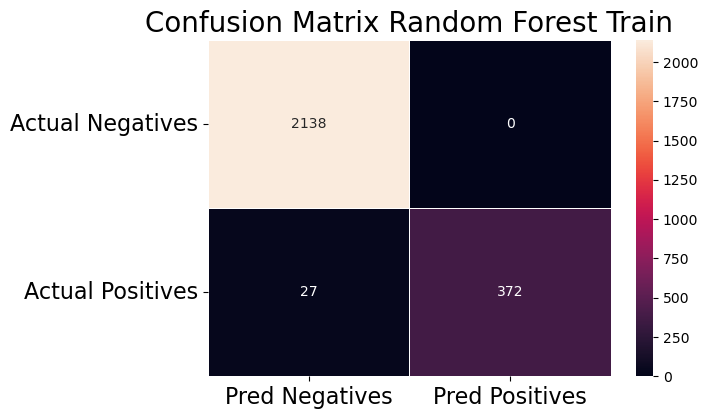

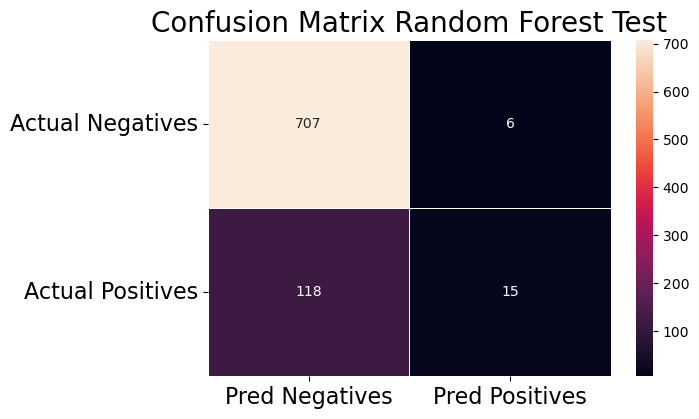

In [42]:
# Matriz de confusión para modelo seleccionado
conf_matrix = confusion_matrix(y_train, model_pred_train)
f, ax = plt.subplots(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", linewidths=.6, ax=ax)
plt.title("Confusion Matrix Random Forest Train", fontsize=20)
plt.subplots_adjust(left=0.15, right=0.99, bottom=0.15, top=0.99)
ax.set_yticks(np.arange(conf_matrix.shape[0]) + 0.5, minor=False)
ax.set_xticklabels(['Pred Negatives', 'Pred Positives'],fontsize=16, rotation=360)
ax.set_yticklabels(['Actual Negatives', 'Actual Positives'], fontsize=16, rotation=360)
plt.show()

conf_matrix = confusion_matrix(y_test, model_pred_test)
f, ax = plt.subplots(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", linewidths=.6, ax=ax)
plt.title("Confusion Matrix Random Forest Test", fontsize=20)
plt.subplots_adjust(left=0.15, right=0.99, bottom=0.15, top=0.99)
ax.set_yticks(np.arange(conf_matrix.shape[0]) + 0.5, minor=False)
ax.set_xticklabels(['Pred Negatives', 'Pred Positives'],fontsize=16, rotation=360)
ax.set_yticklabels(['Actual Negatives', 'Actual Positives'], fontsize=16, rotation=360)
plt.show()

<a id="34"></a> <br>
### 3.4. ROC Curve

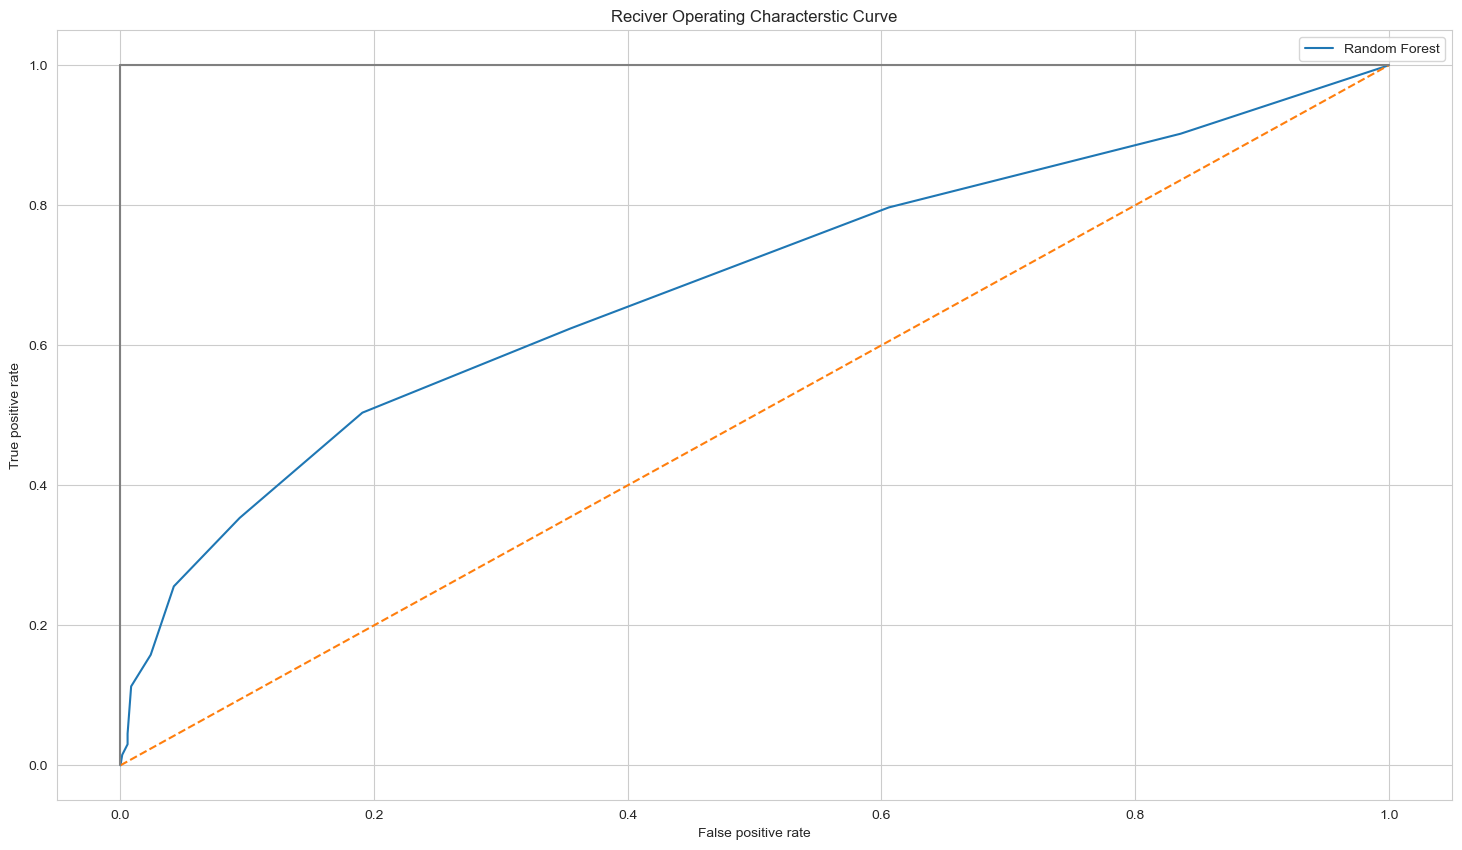

In [43]:
# Obtención de probabilidades de test
probsdmodel_rforest = model.predict_proba(X_test)
predsdmodel_rforest = probsdmodel_rforest[:,1]


# Generación de ROC curve
model_false_positive_rate , model_true_positive_rate , model_threshold = roc_curve(y_test , predsdmodel_rforest)



# Gráfico curva ROC
sns.set_style('whitegrid')
plt.figure(figsize=(18,10))
plt.title('Reciver Operating Characterstic Curve')

plt.plot(model_false_positive_rate , model_true_positive_rate,label="Random Forest")


plt.plot([0,1],ls='--')
plt.plot([0,0],[1,0],c='.5')
plt.plot([1,1],c='.5')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.legend()
plt.show()

<a id="35"></a> <br>
### 3.5. Precission-Recall Curve

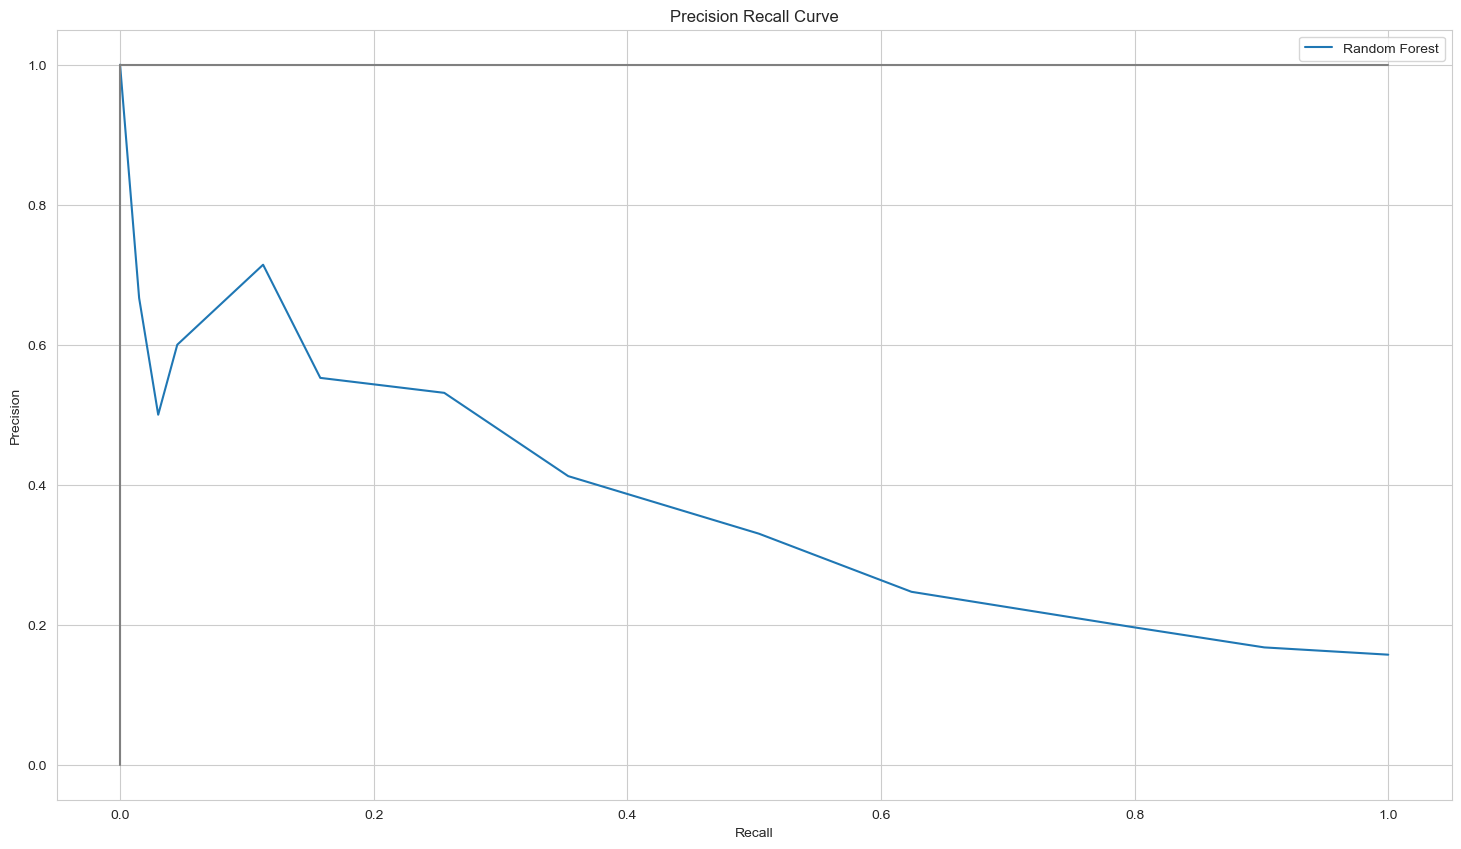

In [45]:
probsdmodel_rforest = model.predict_proba(X_test)
predsdmodel_rforest = probsdmodel_rforest[:,1]

# Generación métricas precision, recall 
rforest_precision , rforest_recall , rforest_threshold = precision_recall_curve(y_test , predsdmodel_rforest)


# Gráfico curva precision recall curve
sns.set_style('whitegrid')
plt.figure(figsize=(18,10))
plt.title('Precision Recall Curve')

plt.plot(rforest_recall , rforest_precision,label="Random Forest")


plt.plot([0,0],[1,0],c='.5')
plt.plot([1,1],c='.5')
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.legend()
plt.show()

<a id="36"></a> <br>
### 3.6. Feature importance 

In [46]:
# Se busca la feature importance con permutation importance
feature_importance = permutation_importance(model, X_test, y_test, n_repeats=5, random_state=0)

In [47]:
# Se crea un dataframe de features importances
importancia_features = pd.DataFrame(feature_importance["importances_mean"], index = X_test.columns, columns=['importancia'])
importancia_features_sort = importancia_features.sort_values('importancia', ascending=False)
importancia_features_sort = importancia_features_sort[importancia_features_sort.importancia != 0]
display(importancia_features_sort)

,importancia
Age,0.012293
AgeStartedWorking,0.009456
JobRole,0.005674
YearsInCurrentRole,0.005674
NumCompaniesWorked,0.004492
MaritalStatus,0.003783
EducationField,0.003783
RelationshipSatisfaction,0.003783
OverTime,0.003783
Department,0.003546


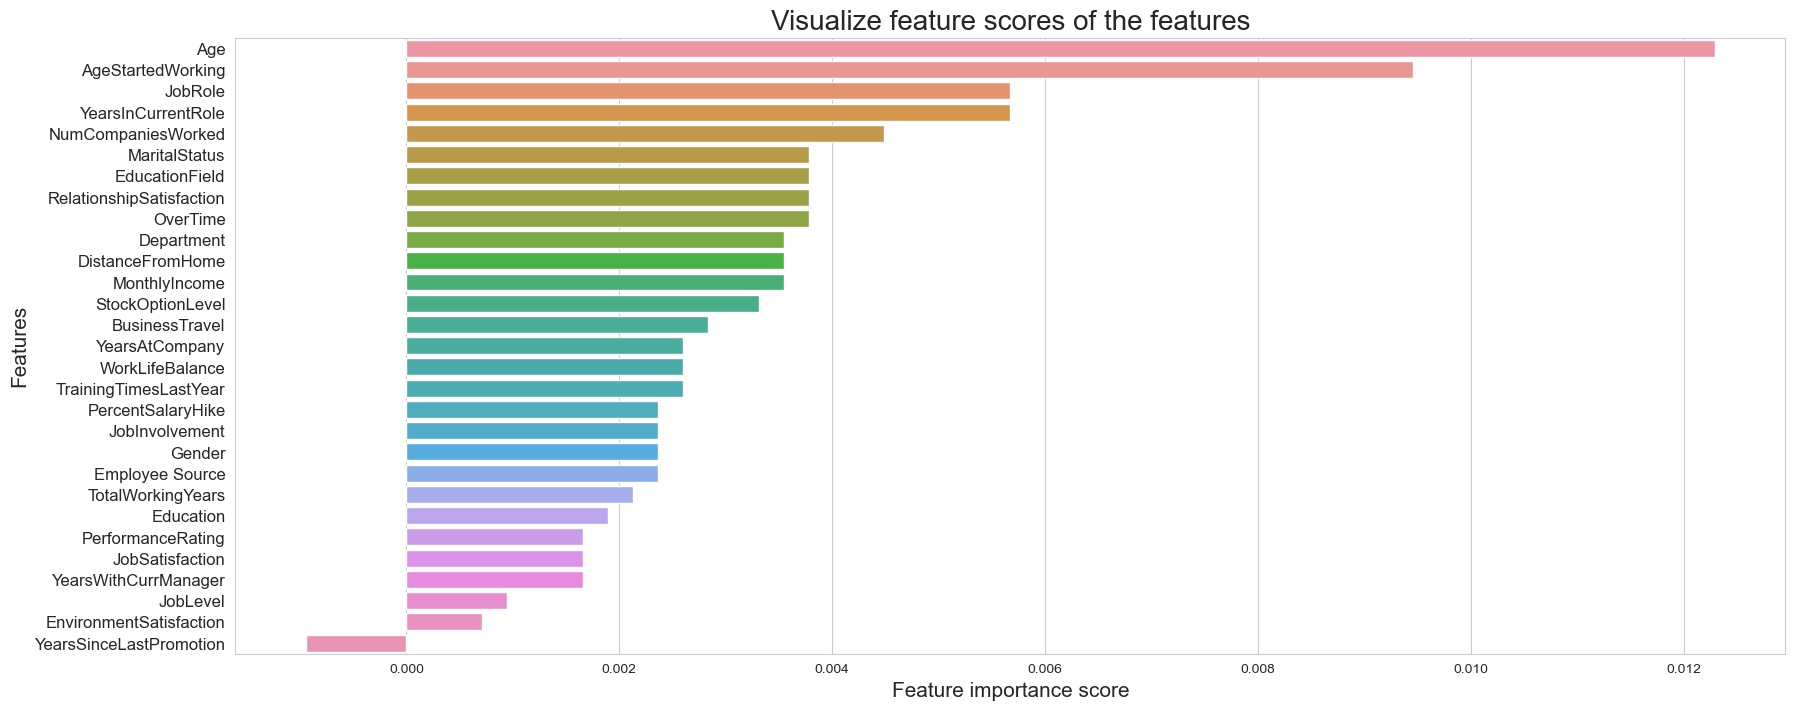

In [48]:
# Creating a seaborn bar plot

f, ax = plt.subplots(figsize=(20, 8))
ax = sns.barplot(x=importancia_features_sort.importancia, y=importancia_features_sort.index, data=importancia_features_sort)
ax.set_title("Visualize feature scores of the features",fontsize=20)
ax.set_yticklabels(importancia_features_sort.index, fontsize=12)
ax.set_xlabel("Feature importance score",fontsize=15)
ax.set_ylabel("Features",fontsize=15)
plt.show()

***
<a id="4"></a> <br>
## 4. Exportación con Shelve

<a id="41"></a> <br>
### 4.1. Exportación con Shelve

In [49]:
rforest = shelve.open('../Models Shelve/03.RandomForest.db')

rforest['modelo'] = model
rforest["metricas"] = df_metricas

rforest.close()